In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")


('ratings_total.txt', <http.client.HTTPMessage at 0x7fa95fd362b0>)

In [3]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력
total_data[:5]


전체 리뷰 개수 : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [4]:
#훈련데이터와 테스트 데이터 분리

total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

# 각 열에 대해서 중복을 제외한 샘플의 수
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('중복을 제거한 총 샘플의 수 :',len(total_data))

중복을 제거한 총 샘플의 수 : 199908


In [5]:
#null 값 유무 체크 
print(total_data.isnull().values.any())

#훈련데이터와 테스트 데이터를 3:1비율로 분류
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)


False


In [6]:
#레이블 분포 확인
#train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  74918
1      1  75013


In [7]:
#데이터 정제

# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

ratings    0
reviews    0
label      0
dtype: int64
전처리 후 테스트용 샘플의 개수 : 49977


/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

In [10]:
#TOKENIZING

mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))


['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [11]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [12]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [15]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))


[('네요', 31802), ('는데', 20197), ('안', 19719), ('어요', 14838), ('있', 13200), ('너무', 13057), ('했', 11766), ('좋', 9803), ('배송', 9677), ('같', 8997), ('어', 8929), ('구매', 8869), ('거', 8861), ('없', 8672), ('아요', 8640), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7985)]


In [17]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39422), ('아요', 21186), ('네요', 19894), ('어요', 18673), ('잘', 18603), ('구매', 16165), ('습니다', 13320), ('있', 12391), ('배송', 12274), ('는데', 11635), ('합니다', 9801), ('했', 9783), ('먹', 9640), ('재', 9274), ('너무', 8398), ('같', 7867), ('만족', 7259), ('거', 6484), ('어', 6330), ('쓰', 6291)]


긍정 리뷰의 평균 길이 : 13.57963286363697
부정 리뷰의 평균 길이 : 17.03147441202381


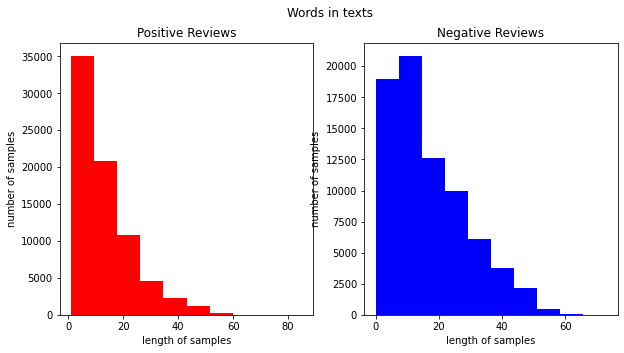

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


In [19]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [21]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40126
등장 빈도가 1번 이하인 희귀 단어의 수: 18274
단어 집합에서 희귀 단어의 비율: 45.54154413597169
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7963870160240529


In [22]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21854


In [23]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.304460051623748


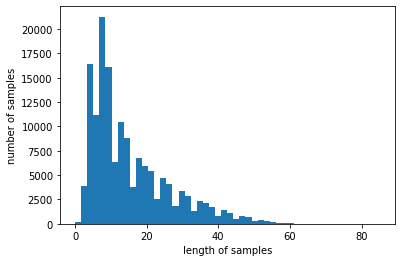

In [24]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [26]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [27]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [28]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2712 - acc: 0.8983
Epoch 00001: val_acc improved from -inf to 0.91693, saving model to best_model.h5
2000/2000 [==============================] - 147s 74ms/step - loss: 0.2712 - acc: 0.8983 - val_loss: 0.2295 - val_acc: 0.9169
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2141 - acc: 0.9227
Epoch 00002: val_acc improved from 0.91693 to 0.92577, saving model to best_model.h5
2000/2000 [==============================] - 148s 74ms/step - loss: 0.2141 - acc: 0.9227 - val_loss: 0.2076 - val_acc: 0.9258
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1974 - acc: 0.9286
Epoch 00003: val_acc improved from 0.92577 to 0.92784, saving model to best_model.h5
2000/2000 [==============================] - 150s 75ms/step - loss: 0.1974 - acc: 0.9286 - val_loss: 0.2040 - val_acc: 0.9278
Epoch 4/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1866 - acc: 0.933

In [32]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 16s 10ms/step - loss: 0.2105 - acc: 0.9247

 테스트 정확도: 0.9247


In [33]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [38]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')
sentiment_predict('배송누락때문에 별 세개 뺐어요')
sentiment_predict('보풀이 많이 일어나는 재질은 아니고 낫배드')
sentiment_predict('좋아요')
sentiment_predict('나쁘지않아요')


98.26% 확률로 긍정 리뷰입니다.
55.63% 확률로 부정 리뷰입니다.
98.47% 확률로 부정 리뷰입니다.
75.20% 확률로 긍정 리뷰입니다.
70.63% 확률로 긍정 리뷰입니다.
